In [15]:
import json, numpy as np, matplotlib.pyplot as plt, matplotlib.image as mpimg

with open('A.json') as f:
    data_a = json.load(f)
with open('B.json') as f:
    data_b = json.load(f)
with open('C.json') as f:
    data_c = json.load(f)
with open('D.json') as f:
    data_d = json.load(f)
with open('E.json') as f:
    data_e = json.load(f)
with open('F.json') as f:
    data_f = json.load(f)

data = [data_a, data_b, data_c, data_d, data_e, data_f]
cases = ['A', 'B', 'C', 'D', 'E', 'F']

In [16]:
process_time_a_star = np.array([[elem['processing_time'] for elem in d if elem['algorithm'] == 'A*'] for d in data])
process_time_rrt_star = np.array([[elem['processing_time'] for elem in d if elem['algorithm'] == 'RRT*'] for d in data])
process_time_rrt_star_without_optim = np.array([[elem['processing_time'] for elem in d if elem['algorithm'] == 'RRT* Without Optimization'] for d in data])

Time performance comparison
---------------------------

On every tests, we can see that A\* performs always better than the worst RRT\*. 
As expected, adding the path post processing adds an offset to the time processing. This effect may not be visible in the individual example, due to the limited number of samples.

A* is better in straight short path (A). On the contrary, RRT* seems better to explore a large portion of the map quickly. With small obstacles, RRT* can quickly build an efficient graph. In C, RRT* instantly sample a point which allows it to avoid the small obstacle. In the same situation, A* has to spend more time to compute a path to avoid the obstacle.

In narrow passages, like in D and E, RRT* performs poorly in some cases, because the nature of the algorithm makes it hard for it to go in a straight line, without getting stuck in an obstacle. However, with the goal in line of sight, like in B and F, RRT* is more efficient than A*.

To conclude, A* may perform less well in some cases. However, it is a lot more stable than RRT\*, which can randomly be a lot more than twice the processing time of A*.

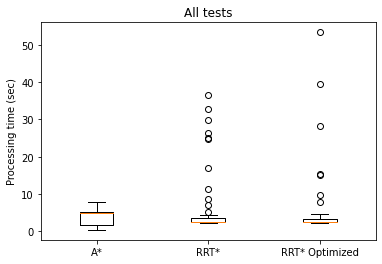

In [22]:
plt.figure()
plt.boxplot([process_time_a_star.reshape(-1), process_time_rrt_star_without_optim.reshape(-1), process_time_rrt_star.reshape(-1)], labels=['A*', 'RRT*', 'RRT* Optimized'])
plt.ylabel('Processing time (sec)')
plt.title('All tests')
plt.savefig('time_all.png', bbox_inches='tight')

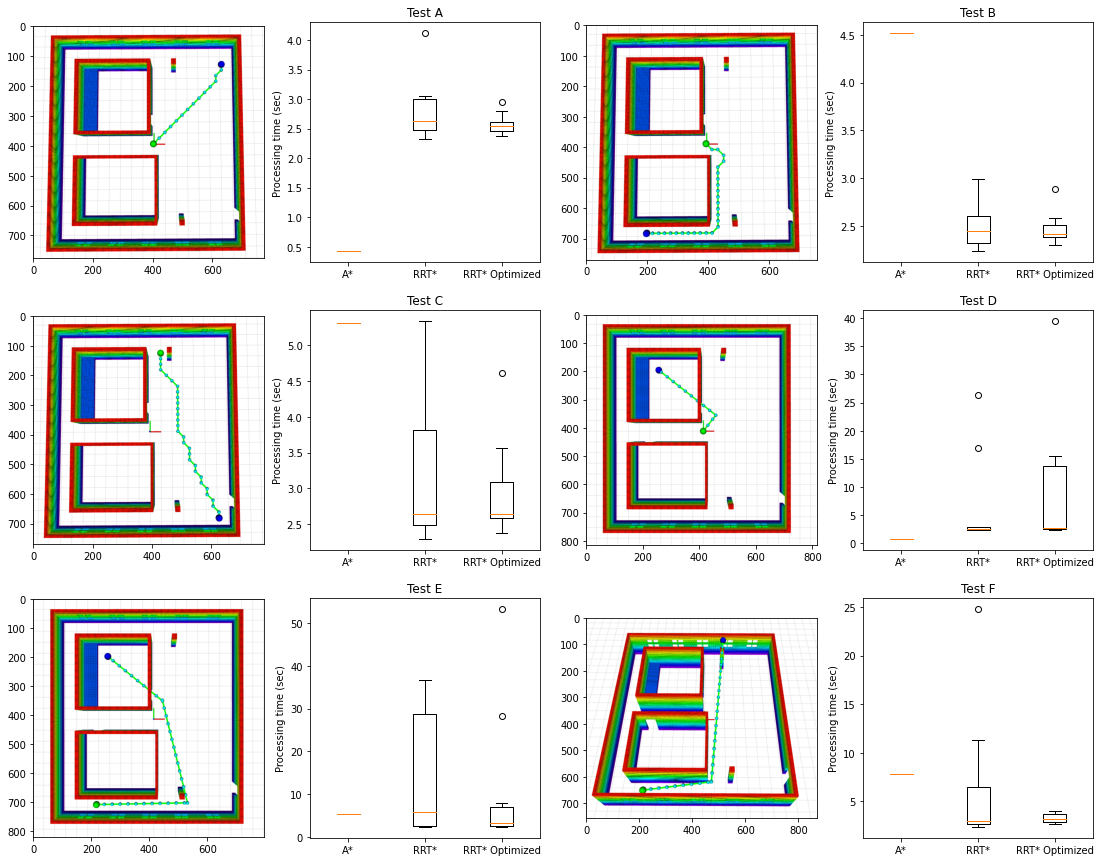

In [26]:
plt.figure(figsize=(19, 15))
for i, (a_star, rrt_star, rrt_star_without) in enumerate(zip(process_time_a_star, process_time_rrt_star, process_time_rrt_star_without_optim)):
    plt.subplot(3, 4, 2*i + 1)
    img = mpimg.imread('{}.png'.format(cases[i]))
    plt.imshow(img)
    plt.subplot(3, 4, 2*i + 2)
    plt.boxplot([a_star, rrt_star_without, rrt_star], labels=['A*', 'RRT*', 'RRT* Optimized'])
    plt.ylabel('Processing time (sec)')
    plt.title('Test {}'.format(cases[i]))
plt.savefig('time_each.png', bbox_inches='tight')    

Rotations over path comparison
------------------------------

Here, we mesure the relative angle between the two directions given by the waypoints of a path.

Most path planning strategies include a smoothing algorithm. We did not incorporate one. So monitoring the variation of the angle along the path computed may not be relevant for the final robotic application. However, it can still give us an idea of the type of output produced by each algorithm.

A* stays quite consistent, with a lot of straight paths and some few turns. However, the property of the A* algorithm makes it do a very sharp turns (either 45° or 90°), which can be hard to use. Especially in straight but diagonal path, A* has to do small turns which are not efficient at all. We could imagine some post processing to apply to the path to improve it.

On the contrary, RRT* without any optimization is doing, as expected, a lot of turns in every directions. This is a result of the randomness of the algorithm. However, the re-routing of the three is probably helping to help keep a coherent structure. This is why we still see a mean of angle of rotation relatively low. We could expect the classic RRT algorithm to work a lot worse compared to RRT*.

Lastly, RRT* optimized is mostly made of straight paths thanks to the over-sampling. Thus, more than the majority of angles are 0°. However, it will be made of a few turns, with mostly random distribution. So this algorithm seems to be quite equivalent to RRT* without optimization, with strong angles going in every directions.

For each algorithm, we can expect a smoothing algorithm to greatly improve the quality of the path.

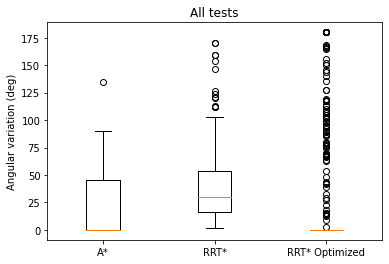

In [27]:
rot_a_star = np.array([e for d in data for elem in d if elem['algorithm'] == 'A*' for e in elem['rotations']])
rot_rrt_star = np.array([e for d in data for elem in d if elem['algorithm'] == 'RRT*' for e in elem['rotations']])
rot_rrt_star_without = np.array([e for d in data for elem in d if elem['algorithm'] == 'RRT* Without Optimization' for e in elem['rotations']])
plt.figure()
plt.boxplot([rot_a_star, rot_rrt_star_without, rot_rrt_star], labels=['A*', 'RRT*', 'RRT* Optimized'])
plt.ylabel('Angular variation (deg)')
plt.title('All tests')
plt.savefig('rot_all.png', bbox_inches='tight')

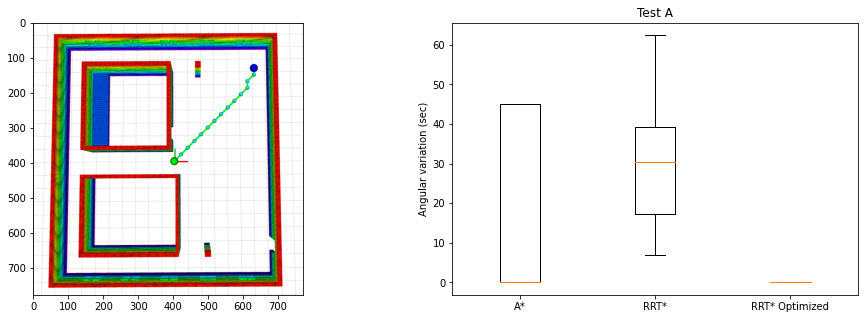

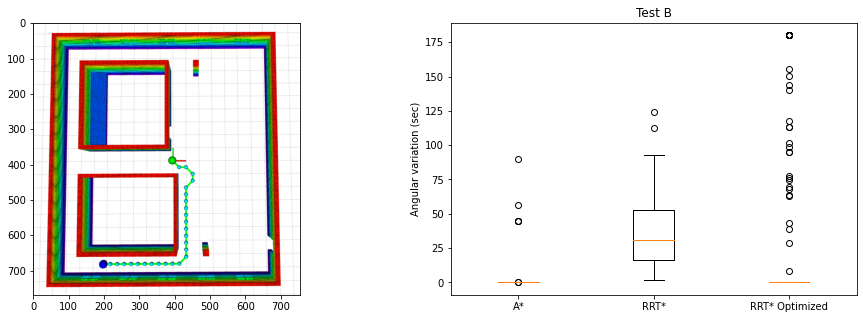

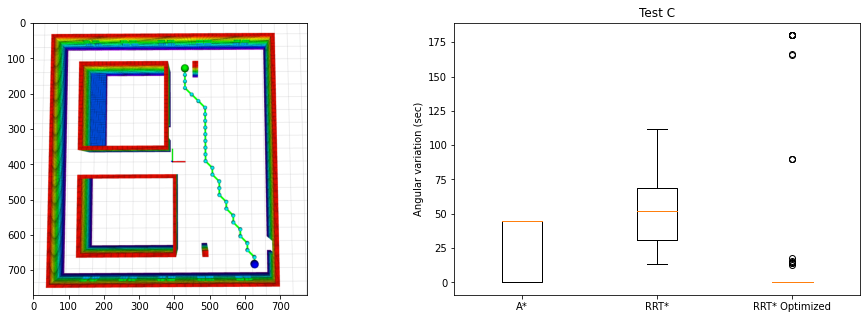

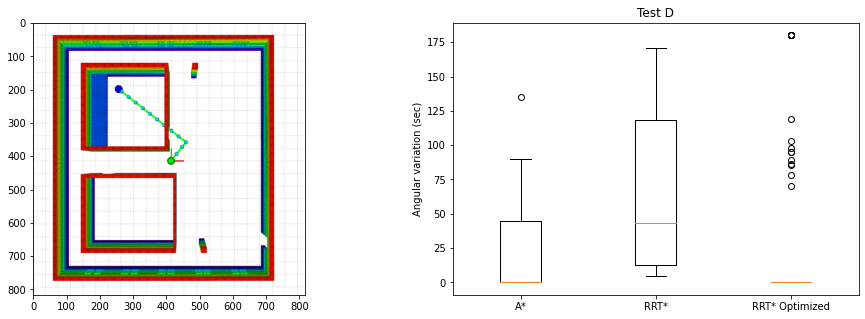

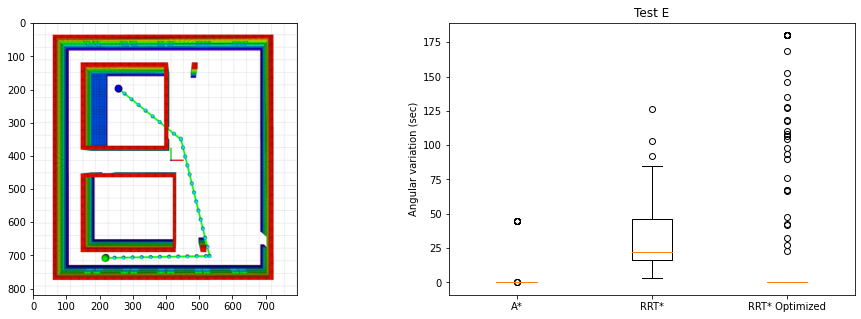

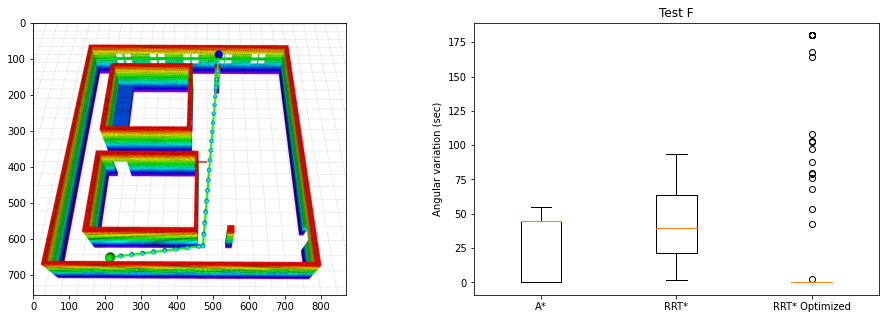

In [9]:
for i, (a_star, rrt_star, rrt_star_without) in enumerate(zip([[e for elem in d if elem['algorithm'] == 'A*' for e in elem['rotations']] for d in data], 
                                                             [[e for elem in d if elem['algorithm'] == 'RRT*' for e in elem['rotations']] for d in data],
                                                             [[e for elem in d if elem['algorithm'] == 'RRT* Without Optimization' for e in elem['rotations']] for d in data])):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    img = mpimg.imread('{}.png'.format(cases[i]))
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.boxplot([a_star, rrt_star_without, rrt_star], labels=['A*', 'RRT*', 'RRT* Optimized'])
    plt.ylabel('Angular variation (sec)')
    plt.title('Test {}'.format(cases[i]))

Relative length comparison
--------------------------

We compare the length of the final computed path. Each length is relative to a straight line path from the start to the goal points. The formula for the relative length is $ \frac{path\_length}{straight\_line\_length} - 1$.

As one could expect, A* is relatively better in a lot pof cases. Its weakness is in diagonal straight paths. On the contrary, RRT* immediately connect to the goal with a line of sight path.

RRT* without optimization can produce a lot of unefficient paths. Theoriticaly, if we ran the algorithm during an infinite time, we would obtain an optimal path. We can see that the added post processing can greatly improve the length and remove unecessary turns that the RRT* is computing.

In cases with narrow passages, like doors, A* is outperforming almost always RRT*. But the RRT* optimization can still reduce the gap between the results.

In case F, in 3D, RRT* optimized is sometimes outperforming A*, which may be because of the straight line situation, which may be even worse in 3D.

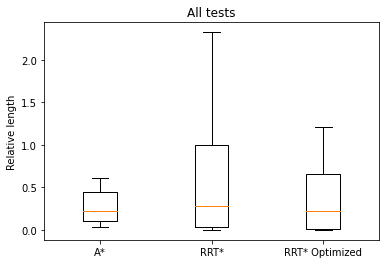

In [28]:
len_a_star = np.array([[elem['relative_length'] for elem in d if elem['algorithm'] == 'A*'] for d in data])
len_rrt_star = np.array([[elem['relative_length'] for elem in d if elem['algorithm'] == 'RRT*'] for d in data])
len_rrt_star_without = np.array([[elem['relative_length'] for elem in d if elem['algorithm'] == 'RRT* Without Optimization'] for d in data])
plt.figure()
plt.boxplot([len_a_star.reshape(-1), len_rrt_star_without.reshape(-1), len_rrt_star.reshape(-1)], labels=['A*', 'RRT*', 'RRT* Optimized'])
plt.ylabel('Relative length')
plt.title('All tests')
plt.savefig('len_all.png', bbox_inches='tight')

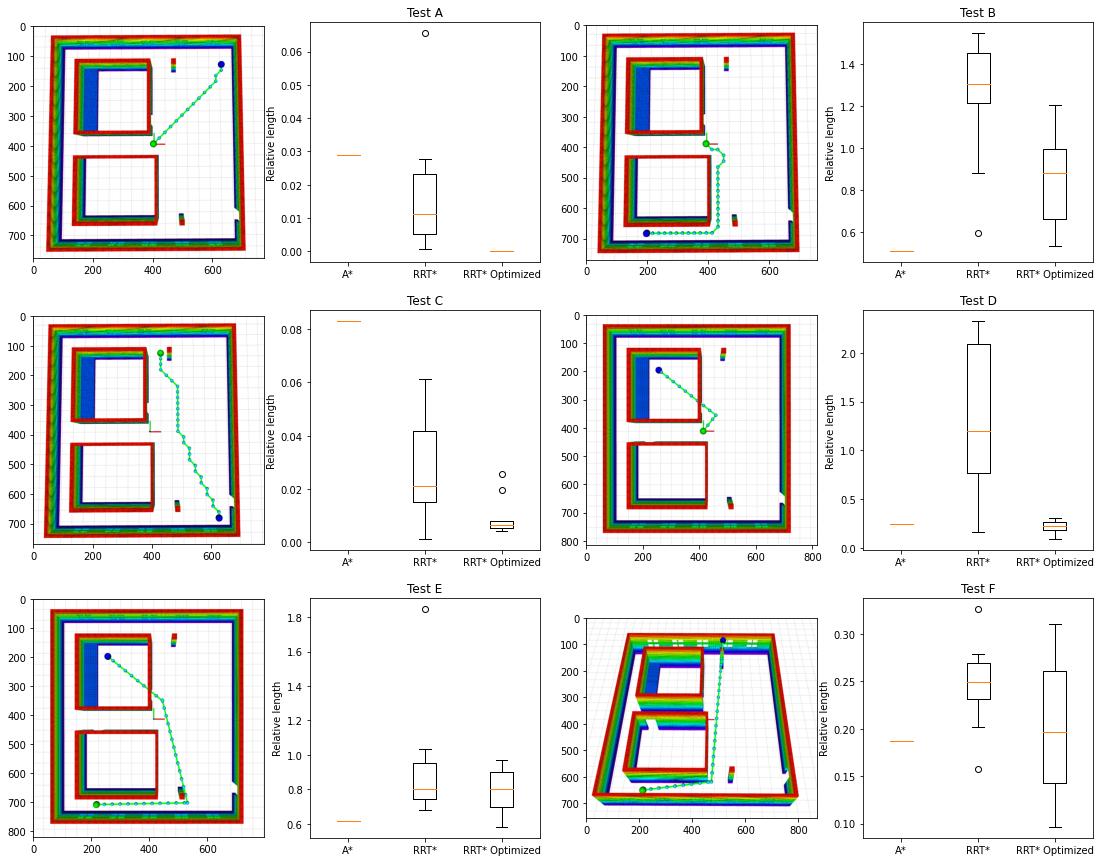

In [30]:
plt.figure(figsize=(19, 15))
for i, (a_star, rrt_star, rrt_star_without) in enumerate(zip(len_a_star, len_rrt_star, len_rrt_star_without)):
    plt.subplot(3, 4, i*2 + 1)
    img = mpimg.imread('{}.png'.format(cases[i]))
    plt.imshow(img)
    plt.subplot(3, 4, i*2 + 2)
    plt.boxplot([a_star, rrt_star_without, rrt_star], labels=['A*', 'RRT*', 'RRT* Optimized'])
    plt.ylabel('Relative length')
    plt.title('Test {}'.format(cases[i]))
plt.savefig('len_each.png', bbox_inches='tight')

Collision checks comparison
--------------------------

Here, we discuss how the number of collision checks to the octomap API may affect the path planning algorithm. Theses functions may be quite computationnaly expensive depending on the size of the environment and the amount of information accessible by the robot. Thus, we should minimize the amount of times they are called.

A* is always the most efficient algorithm in this regard. Indeed, with RRT*, for every re-routing, a lot of calls to the octomap API have to be done. 

We would expect the optimized RRT* to make slightly more calls than RRT*, since to execute some post processing optimization, it needs to do a lot of collision checks. Therefore, the number of tests done is probably not enough to correctly evaluate the relationship between the two algorithms.

Additionnaly, we can see that there does not seem to be a correlation between each of these visualization and the time performances graph, which probably means that, in this setup, the calls to the octomap API are not too computationnaly expensive, contrarily to our expectations.

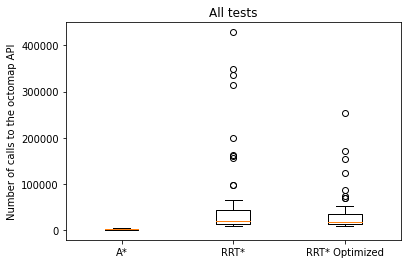

In [32]:
chk_a_star = np.array([[elem['collision_checks'] for elem in d if elem['algorithm'] == 'A*'] for d in data])
chk_rrt_star = np.array([[elem['collision_checks'] for elem in d if elem['algorithm'] == 'RRT*'] for d in data])
chk_rrt_star_without = np.array([[elem['collision_checks'] for elem in d if elem['algorithm'] == 'RRT* Without Optimization'] for d in data])
plt.figure()
plt.boxplot([chk_a_star.reshape(-1), chk_rrt_star_without.reshape(-1), chk_rrt_star.reshape(-1)], labels=['A*', 'RRT*', 'RRT* Optimized'])
plt.ylabel('Number of calls to the octomap API')
plt.title('All tests')
plt.savefig('oct_all.png', bbox_inches='tight')

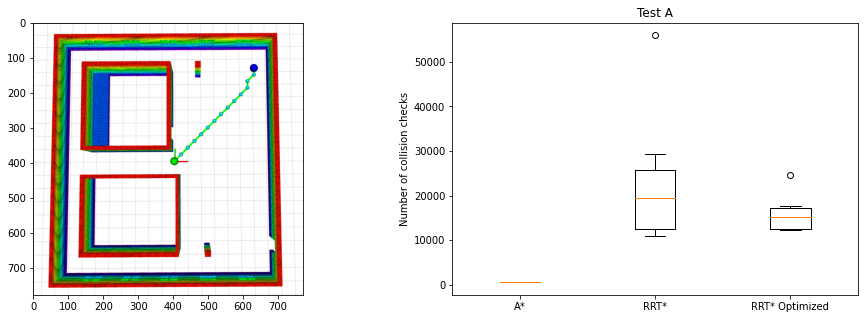

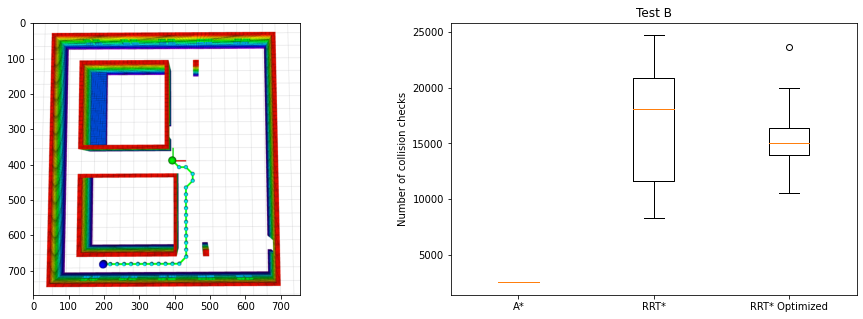

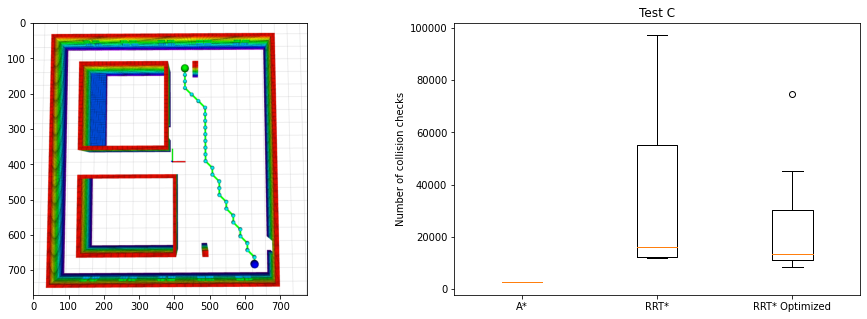

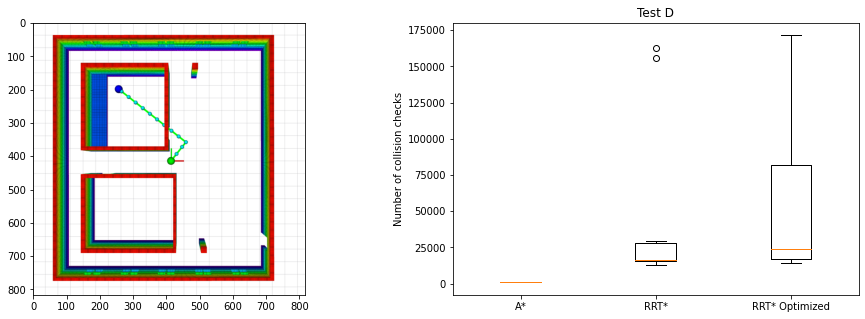

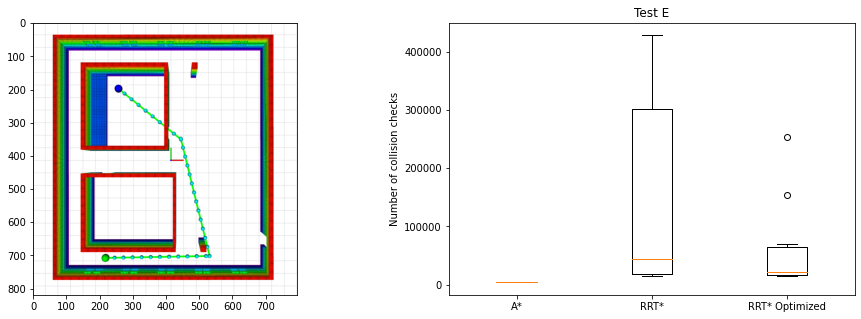

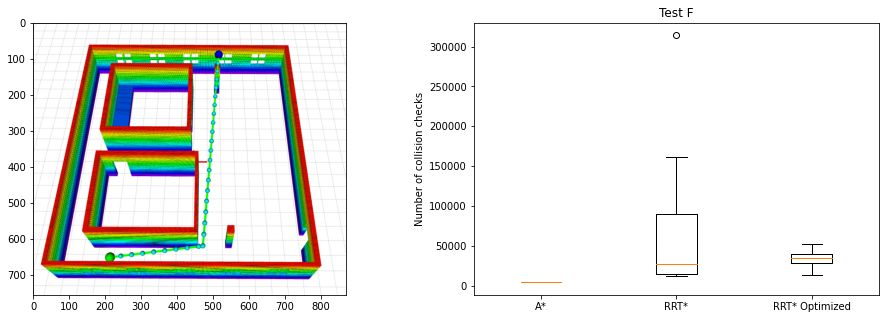

In [30]:
for i, (a_star, rrt_star, rrt_star_without) in enumerate(zip(chk_a_star, chk_rrt_star, chk_rrt_star_without)):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    img = mpimg.imread('{}.png'.format(cases[i]))
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.boxplot([a_star, rrt_star_without, rrt_star], labels=['A*', 'RRT*', 'RRT* Optimized'])
    plt.ylabel('Number of collision checks')
    plt.title('Test {}'.format(cases[i]))

Waypoints distance comparison
-----------------------------

Here, we compare the individual distance between each waypoint of a path.

A* and the RRT* optimized algorithms are outperforming by a huge margin the simple RRT*. This is expected since the optimized RRT* especially introduce an over-sampling function to reduce the space between waypoint. RRT* is only mostly centered around the waypoint increment, which is not respected once the goal is in line of sight.

A* is also extremely efficient, because it discretise the space in grid a finite size. So by reducing this parameter, we can reduce the waypoint distance even more, at the cost of a big increase in processing time.

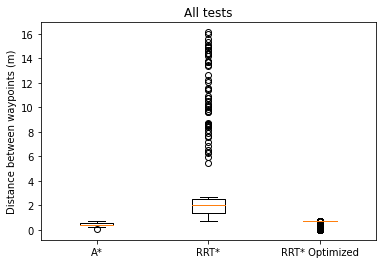

In [33]:
wpd_a_star = np.array([e for d in data for elem in d if elem['algorithm'] == 'A*' for e in elem['waypoints_distance']])
wpd_rrt_star = np.array([e for d in data for elem in d if elem['algorithm'] == 'RRT*' for e in elem['waypoints_distance']])
wpd_rrt_star_without = np.array([e for d in data for elem in d if elem['algorithm'] == 'RRT* Without Optimization' for e in elem['waypoints_distance']])
plt.figure()
plt.boxplot([wpd_a_star.reshape(-1), wpd_rrt_star_without.reshape(-1), wpd_rrt_star.reshape(-1)], labels=['A*', 'RRT*', 'RRT* Optimized'])
plt.ylabel('Distance between waypoints (m)')
plt.title('All tests')
plt.savefig('wpd_all.png', bbox_inches='tight')

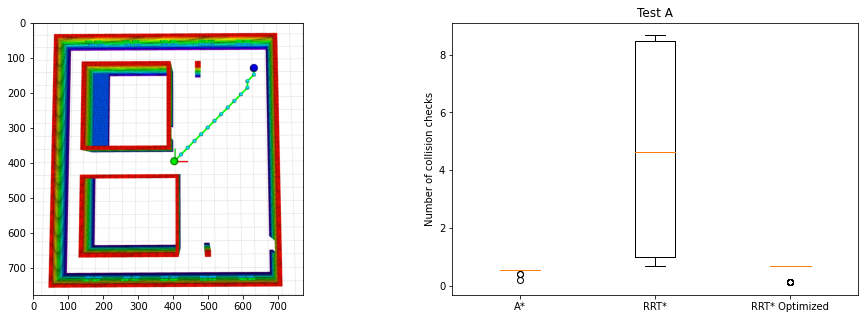

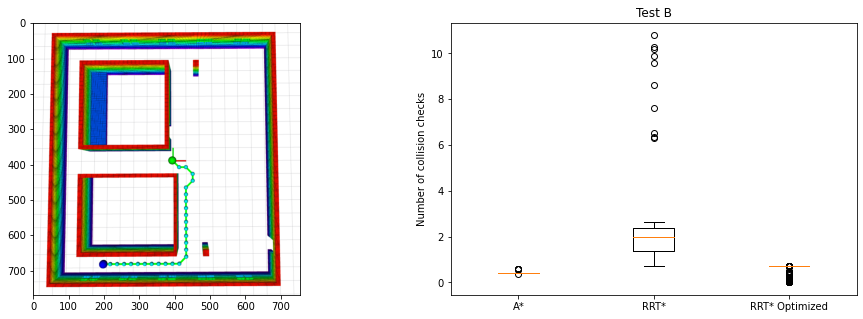

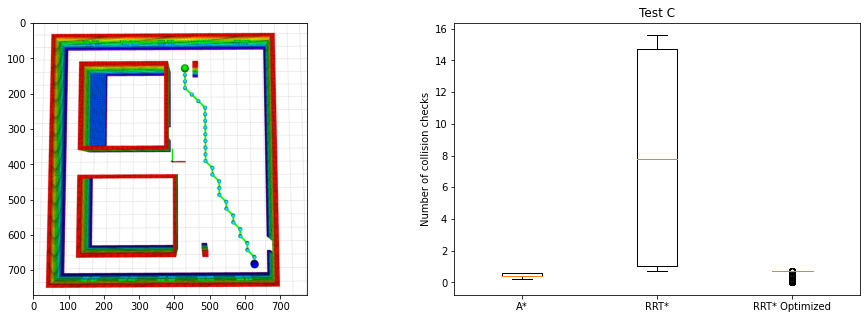

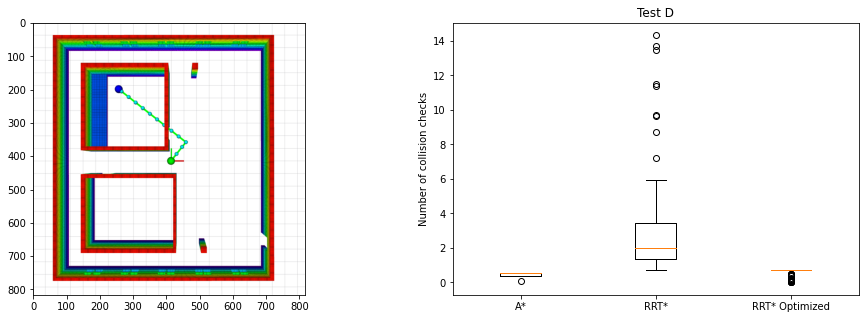

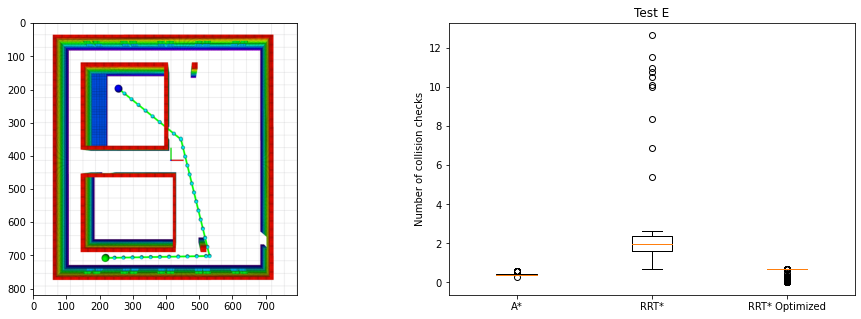

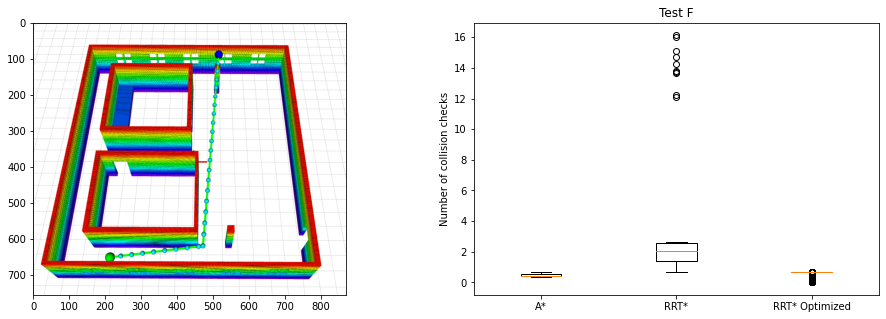

In [37]:
for i, (a_star, rrt_star, rrt_star_without) in enumerate(zip([[e for elem in d if elem['algorithm'] == 'A*' for e in elem['waypoints_distance']] for d in data], 
                                                             [[e for elem in d if elem['algorithm'] == 'RRT*' for e in elem['waypoints_distance']] for d in data],
                                                             [[e for elem in d if elem['algorithm'] == 'RRT* Without Optimization' for e in elem['waypoints_distance']] for d in data])):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    img = mpimg.imread('{}.png'.format(cases[i]))
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.boxplot([a_star, rrt_star_without, rrt_star], labels=['A*', 'RRT*', 'RRT* Optimized'])
    plt.ylabel('Number of collision checks')
    plt.title('Test {}'.format(cases[i]))

## Additionnal content

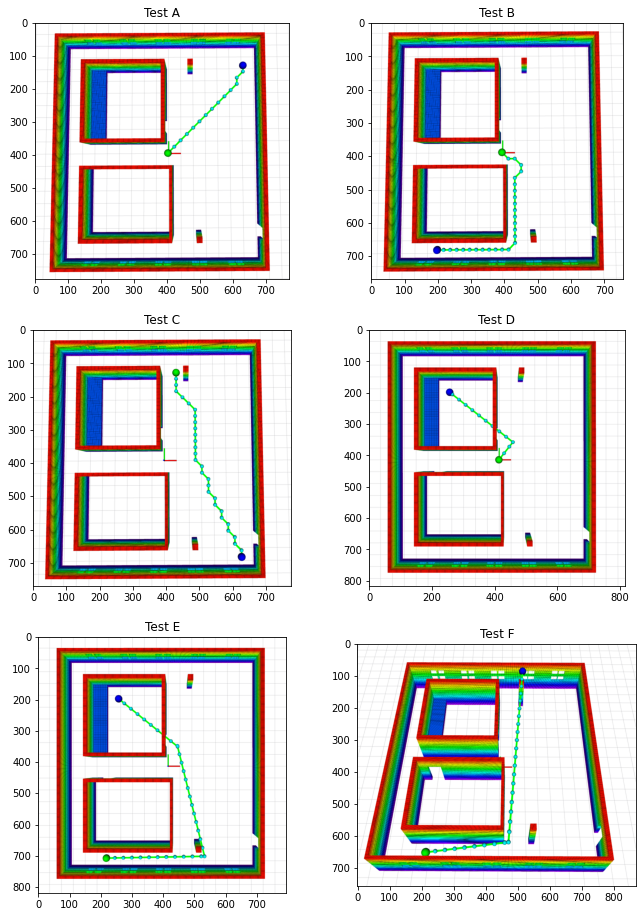

In [13]:
plt.figure(figsize=(11, 16))
for i, case in enumerate(cases):
    plt.subplot(3, 2, i + 1)
    img = mpimg.imread('{}.png'.format(case))
    plt.imshow(img)
    plt.title('Test {}'.format(case))
    plt.savefig('tests.png', bbox_inches='tight', pad_inches=0)